In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

def identify_best_column_with_data(df, target_station):
    """
    Identifica la mejor columna que tiene la menor cantidad de valores nulos
    en las filas donde la estación objetivo tiene valores faltantes.

    Parameters:
    - df: DataFrame que contiene las estaciones y los datos de las mismas.
    - target_station: La estación que tiene valores faltantes y que se quiere completar.

    Returns:
    - best_column: Nombre de la columna con la menor cantidad de valores nulos en las filas donde la estación objetivo tiene valores faltantes.
    """
    target_nan_df = df[df[target_station].isna()]
    missing_counts = target_nan_df.drop(columns=[target_station]).isna().sum()
    best_column = missing_counts.idxmin()
    return best_column


def simple_regression(df, best_column, target_station):
    print(df.shape)
    
    # Crear una copia del DataFrame original para trabajar sobre ella
    merged_df = df.copy()

    # Filtrar las filas donde la estación objetivo tiene valores NaN
    target_nan_df = merged_df[merged_df[target_station].isna()]

    # Filtrar las filas donde la columna best_column no tiene valores NaN (las que se pueden completar)
    target_nan_df_non_nan_other_columns_df = target_nan_df[target_nan_df[best_column].notna()]

    # Si no hay suficientes datos para completar, regresar el DataFrame sin modificaciones
    if target_nan_df_non_nan_other_columns_df.empty:
        print(f"No hay suficientes datos para completar la columna '{target_station}' con la columna '{best_column}'")
        return merged_df

    # Filtrar las filas completas (sin NaN) en 'best_column' y 'target_station' para entrenamiento
    remaining_df = df[['Fecha', best_column, target_station]].dropna()
    
    # Si no hay suficientes datos para entrenamiento, regresar el DataFrame sin modificaciones
    if len(remaining_df) < 2:
        print(f"No hay suficientes datos para entrenar el modelo en '{target_station}' con '{best_column}'")
        return merged_df

    # Train-test split (70% train, 30% test)
    train_df, test_df = train_test_split(remaining_df, test_size=0.3, random_state=42)

    # Inicializar el modelo de regresión lineal
    linear_reg = LinearRegression()

    # Entrenar el modelo
    X_train = train_df[[best_column]]
    y_train = train_df[target_station]
    linear_reg.fit(X_train, y_train)

    # Predecir y actualizar los valores faltantes en target_station
    for index, row in target_nan_df_non_nan_other_columns_df.iterrows():
        # Crear un DataFrame con el valor de 'best_column' para mantener los nombres de las características
        X_pred_df = pd.DataFrame([[row[best_column]]], columns=[best_column])
        predicted_value = linear_reg.predict(X_pred_df)[0]

        # Verificar si el valor predicho es negativo o cercano a 0, y ajustarlo si es necesario
        if predicted_value < 0 or np.isclose(predicted_value, 0):
            predicted_value = 0

        # Actualizar el valor predicho en el DataFrame original (copia)
        merged_df.at[index, target_station] = np.round(predicted_value, 2)

    # Verificar que el número de filas se mantenga igual al original
    assert len(merged_df) == len(df), "El número de filas no coincide con el original"

    return merged_df



def complete_missing_data(df, target_station, selected_model=None):
    dropped_df = df[df.isna().any(axis=1)]
    target_nan_df = df[df[target_station].isna()]
    target_nan_df_non_nan_other_columns_df = target_nan_df[target_nan_df.drop(columns=[target_station]).notna().all(axis=1)]
    rows_to_keep = dropped_df.index.difference(target_nan_df_non_nan_other_columns_df.index)
    dropped_df_not_in_target_nan = dropped_df.loc[rows_to_keep]

    
    remaining_df = df.dropna()
    if len(remaining_df) < 2:
        print(f"No hay suficientes datos para realizar regresión en la estación: {target_station}")
        return df, selected_model, None, None, None
            
    if selected_model is None:
        train_df, test_df = train_test_split(remaining_df, test_size=0.3, random_state=42)
        linear_reg = LinearRegression()
        random_forest_reg = RandomForestRegressor()

        def root_mean_squared_error(y_true, y_pred):
            return np.sqrt(mean_squared_error(y_true, y_pred))

        X_train = train_df.drop([target_station, 'Fecha'], axis=1)
        y_train = train_df[target_station]
        linear_reg.fit(X_train, y_train)
        random_forest_reg.fit(X_train, y_train)

        X_test = test_df.drop([target_station, 'Fecha'], axis=1)
        y_test = test_df[target_station]
        linear_reg_rmse = root_mean_squared_error(y_test, linear_reg.predict(X_test))
        random_forest_rmse = root_mean_squared_error(y_test, random_forest_reg.predict(X_test))

        if linear_reg_rmse < random_forest_rmse:
            selected_model = linear_reg
            selected_model_name = 'Linear Regression'
        else:
            selected_model = random_forest_reg
            selected_model_name = 'Random Forest'
    else:
        selected_model_name = "Pre-trained model"

    feature_names = [col for col in df.columns if col not in [target_station, 'Fecha']]
    for index, row in target_nan_df_non_nan_other_columns_df.iterrows():
        X_pred = pd.DataFrame([row[feature_names].values], columns=feature_names)
        predicted_value = selected_model.predict(X_pred)[0]
        if predicted_value < 0 or np.isclose(predicted_value, 0):
            predicted_value = 0
        target_nan_df_non_nan_other_columns_df.loc[index, target_station] = np.round(predicted_value, 2)

    #merged_df = pd.concat([target_nan_df_non_nan_other_columns_df, df.dropna(), dropped_df_not_in_target_nan], ignore_index=True)
    
    #merged_df.sort_values(by='Fecha', inplace=True)

    merged_df = pd.concat([target_nan_df_non_nan_other_columns_df, remaining_df,dropped_df_not_in_target_nan], ignore_index=True)
    merged_df.sort_values(by='Fecha', inplace=True)
    return merged_df, selected_model, None, None, selected_model_name

def complete_until_no_nan(df):
    nan_percentages = df.isna().mean() * 100
    ordered_columns = nan_percentages.sort_values().index.tolist()
    ordered_columns.pop(0)

    resultados = {
        'Gauge': [],
        'Selected Model': []
    }

    previous_nan_sum = nan_percentages.sum()
    model_rg = None
    linear_reg = None

    models_list = []
    
    k = 0
    while nan_percentages.sum() > 0:
        print(f"Porcentajes de NaN: \n{nan_percentages}")

        for idx,gauge in enumerate(ordered_columns):
            if df[gauge].isna().sum() > 0:
                if (k == 0):
                    df, model_rg, _, _, model_name = complete_missing_data(df, gauge, selected_model=model_rg)
                    models_list.append(model_rg)
                    model_rg = None
                    resultados['Gauge'].append(gauge)
                    resultados['Selected Model'].append(model_name)
                    print(f"Selected Model for {gauge}: {model_name}")
                else:
                    df, model_rg, _, _, model_name = complete_missing_data(df, gauge, selected_model=models_list[idx])
                    

        nan_percentages = df.isna().mean() * 100
        current_nan_sum = nan_percentages.sum()

        if current_nan_sum >= previous_nan_sum:
            print("No hubo mejora en los valores faltantes, buscando la mejor columna para completar...")
            for gauge in ordered_columns:
                if df[gauge].isna().sum() > 0:
                    
                    best_column = identify_best_column_with_data(df.iloc[:, 1:], gauge)
                    print(f"Usando la columna {best_column} para completar {gauge}")
                    df = simple_regression(df, best_column, gauge)
                    linear_reg = None
                    print(f"Regresión simple completada para {gauge}")

        if (k > 10):
            break
            
        k = k + 1
        previous_nan_sum = current_nan_sum

    return df, pd.DataFrame(resultados)



In [2]:
obs=pd.read_csv('../data/Estaciones/gauge.csv',sep=',')
#obs['Fecha'] = pd.to_datetime(obs['Fecha'], dayfirst=True)
#obs['Fecha'] = pd.to_datetime(obs['Fecha'])
#obs.set_index('Fecha',inplace=True)
obs.head()

,Fecha,chusis,chalaco,huamarca,huancabamba,miraflores
0,1980-01-01,0.0,0.0,0.4,2.1,0.0
1,1980-01-02,0.0,0.0,0.0,0.0,0.0
2,1980-01-03,0.0,0.0,0.0,1.5,0.0
3,1980-01-04,0.0,0.0,0.0,0.0,0.0
4,1980-01-05,0.0,0.0,0.0,0.0,0.0


In [3]:
# Ejemplo de uso:
df_completado, resultados_df = complete_until_no_nan(obs)
# print(resultados_df)

Porcentajes de NaN: 
Fecha           0.000000
chusis         17.406340
chalaco         4.178674
huamarca        3.940922
huancabamba     3.350144
miraflores      7.536023
dtype: float64
Selected Model for huancabamba: Linear Regression
Selected Model for huamarca: Linear Regression
Selected Model for chalaco: Linear Regression
Selected Model for miraflores: Linear Regression
Selected Model for chusis: Linear Regression
Porcentajes de NaN: 
Fecha          0.000000
chusis         6.563401
chalaco        1.988473
huamarca       2.672911
huancabamba    2.759366
miraflores     5.036023
dtype: float64
No hubo mejora en los valores faltantes, buscando la mejor columna para completar...
Usando la columna huamarca para completar huancabamba
(13880, 6)
Regresión simple completada para huancabamba
Usando la columna huancabamba para completar huamarca
(13880, 6)
Regresión simple completada para huamarca
Usando la columna huamarca para completar chalaco
(13880, 6)
Regresión simple completada para c

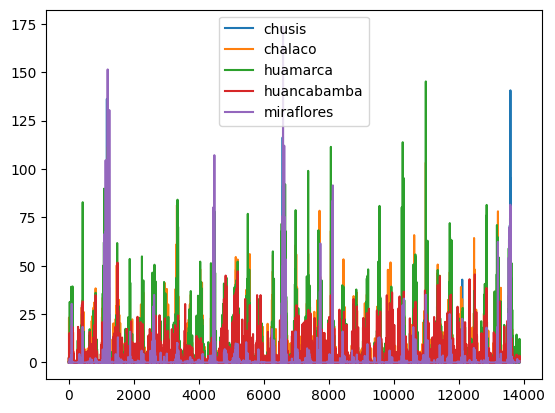

In [184]:
df_completado.plot()
plt.show()

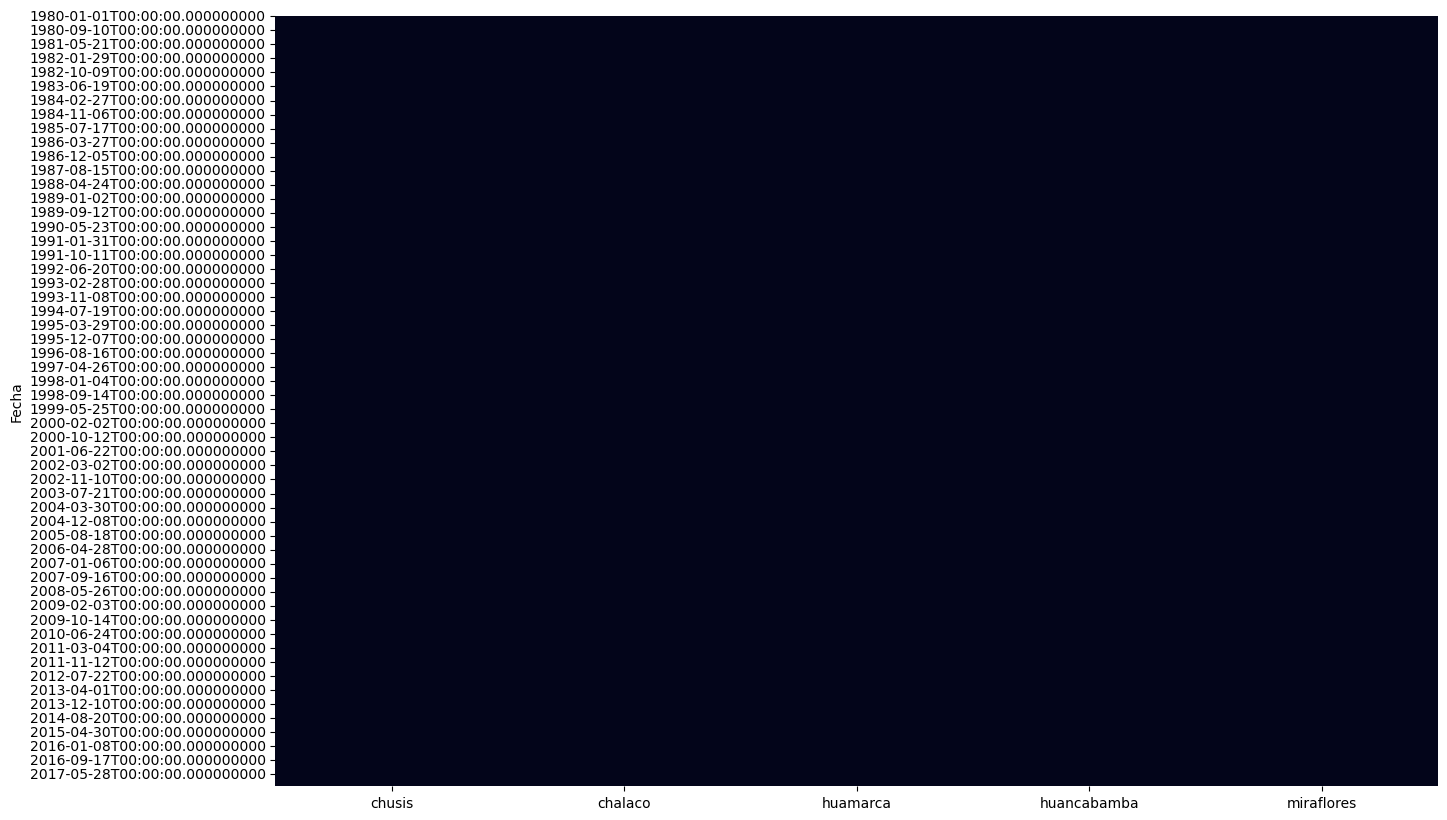

In [4]:
df_completado['Fecha'] = pd.to_datetime(df_completado['Fecha'])
df_completado.set_index('Fecha',inplace=True)
plt.figure(figsize=(15,10))
sns.heatmap(df_completado.isnull(), cbar=False)
plt.show()

In [5]:
df_completado.isna().mean() * 100

chusis         0.007205
chalaco        0.007205
huamarca       0.007205
huancabamba    0.007205
miraflores     0.007205
dtype: float64

In [6]:
df_completado.describe()

,chusis,chalaco,huamarca,huancabamba,miraflores
count,13879.000000,13879.000000,13879.000000,13879.000000,13879.000000
mean,0.251308,2.846420,2.975227,1.414915,0.584207
std,3.165741,7.058831,8.157852,3.890821,5.173917
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.000000,1.800000,0.800000,0.000000
max,140.600000,103.300000,145.200000,51.600000,173.600000


In [7]:
df_completado.shape

(13880, 5)

In [8]:
df = df_completado
df[df.isna().all(axis=1)].index

DatetimeIndex(['2006-09-30'], dtype='datetime64[ns]', name='Fecha', freq=None)

In [10]:
# Find indices where all row values are NaN
nan_rows_index = df[df.isna().all(axis=1)].index

# Select the rows where all values are NaN using .loc
nan_rows_df = df.loc[nan_rows_index]

In [11]:
nan_rows_df

,chusis,chalaco,huamarca,huancabamba,miraflores
Fecha,,,,,
2006-09-30,NaN,NaN,NaN,NaN,NaN
